In [1]:
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

In [2]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam)
point_predictor = SamPredictor(sam)

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [4]:
def select_random_pixels_smart(array):
    true_indices = np.argwhere(array)
    false_indices = np.argwhere(~array)

    # Randomly select a point from "true" and "false" indices
    random_true_index = list(random.choice(true_indices))
    random_false_index = list(random.choice(false_indices))
    
    labeled_array, num_features = ndimage.label(array)
    component_sizes = np.bincount(labeled_array.ravel())
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    largest_component_coords = np.argwhere(labeled_array == largest_component_label)
    center_of_mass = largest_component_coords.mean(axis=0)
    rounded_center = np.round(center_of_mass).astype(int)

    return [rounded_center, random_false_index]
def select_random_pixels(image, num_pixels=1, percentage=0.05):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the threshold value for the darkest 10% of pixels
    top_half = gray_image[:gray_image.shape[0] // 2]
    sorted_pixels = np.sort(top_half.ravel())
    threshold_index = int(len(sorted_pixels) * percentage)
    threshold_value = sorted_pixels[threshold_index]

    # Get the coordinates of the darkest 10% pixels
    top_half = gray_image.shape[0] // 2
    mask = (gray_image <= threshold_value) & (np.indices(gray_image.shape)[0] < top_half)      
    rows, cols = np.where(mask)
    darkest_pixels_image = np.copy(image)
    darkest_pixels_image[mask] = [0, 0, 255]  # Highlight darkest pixels in red

    # Display the image using Matplotlib
    

    # Randomly select two pixels from the filtered darkest pixels
    selected_indices = random.sample(range(len(rows)), min(num_pixels, len(rows)))
    selected_pixels = [(cols[i], rows[i]) for i in selected_indices]
    #plt.figure()
    #plt.imshow(cv2.cvtColor(darkest_pixels_image, cv2.COLOR_BGR2RGB))
    #show_points(np.array(selected_pixels), np.array([1]), plt.gca())

    #plt.axis('off')
    #plt.show()
    return selected_pixels

In [16]:
def make_mask(directory_path, prediction_path, filename):
    #print(filename)
    image = cv2.imread(os.path.join(directory_path, filename))
    #if os.path.exists(os.path.join(prediction_path, filename.replace("jpg", "png"))):
        #print("hi")
    image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace("jpg", "png")),  cv2.IMREAD_GRAYSCALE) < 178, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace("jpg", "png")),  cv2.IMREAD_GRAYSCALE) < 168, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace("jpg", "png")),  cv2.IMREAD_GRAYSCALE) < 100, 0, 1)
    if image_mask.sum() == 0:
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    point_predictor.set_image(image)
    input_point = select_random_pixels_smart(image_mask)
    input_point2 = [0,0]
    input_point2[1] = input_point[0][0] * (image.shape[0]/image_mask.shape[0])
    input_point2[0] = input_point[0][1] * (image.shape[1]/image_mask.shape[1])
    #input_point = np.round(np.array([input_point2]))
    
    input_point3 = [0,0]
    input_point3[1] = input_point[1][0] * (image.shape[0]/image_mask.shape[0])
    input_point3[0] = input_point[1][1] * (image.shape[1]/image_mask.shape[1])
    input_point4 = np.array(np.round([input_point2, input_point3]))
    
    input_label = np.array([1, 0])

    show_points(input_point4, input_label, plt.gca())
    #plt.imshow(image)
    masks, scores, logits = point_predictor.predict(
    point_coords=input_point4,
    point_labels=input_label,
    multimask_output=False,
    )
    show_mask(masks, plt.gca())
    binary_mask = masks[0]
    true_count = np.count_nonzero(binary_mask)
    false_count = binary_mask.size - true_count


    binary_array = binary_mask.astype(np.uint8) * 255
    output_path = os.path.join("../pytorch-nested-unet/inputs/ISIC_aug_50/masks/0", filename.replace(".jpg", ".png"))
    plt.imsave(output_path, binary_array, cmap='gray')


In [ ]:
image = cv2.imread("../pytorch-nested-unet/inputs/breast-cancer/images/benign (100).png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
from scipy import ndimage

#make_mask("../pytorch-nested-unet/inputs/breast-cancer/images/", "../pytorch-nested-unet/outputs/breast-cancer-small_NestedUNet_woDS/0/", "benign (100).png")



In [ ]:
plt.figure()
plt.imshow(image)
pts = np.array([[16, 20],[ 51, 2]])
show_points(pts, np.array([1, 1]), plt.gca())

plt.axis('off')
plt.show()

100%|███████████████████████████████████████████| 51/51 [00:54<00:00,  1.08s/it]


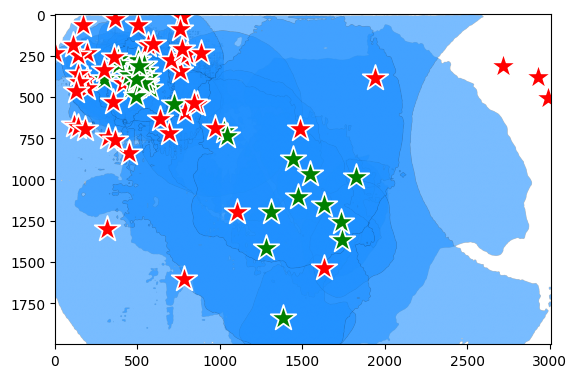

In [17]:
import os
from tqdm import tqdm
directory_path = "../pytorch-nested-unet/inputs/ISIC_aug_50/images/"  # Replace with the actual directory path

prediction_path = "../pytorch-nested-unet/outputs/ISBI_small_NestedUNet_woDS/ISBI2016_ISIC_Part3B_Training_Data/0/"
#print(os.listdir(prediction_path))
for filename in tqdm(os.listdir(directory_path)):
    if os.path.isfile(os.path.join(directory_path, filename)):
        make_mask(directory_path, prediction_path, filename)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
